In [2]:
from PartialCointegration import *
from PCISimulation import *
import xarray as xr


def f_generate_data(params:list, var_values:list, max_sample_size:int, nb_sims:int):

    if params[2] is None:
        alpha, beta, _, sigma_m, sigma_r, sigma_x = params
        rho_values = var_values

        X1_data = []
        X2_data = []

        for rho in rho_values:

            X1_simulations = []
            X2_simulations = []

            for i in range(nb_sims):
                data_generator = pci_generator(max_sample_size, alpha, beta, rho, sigma_m, sigma_r, sigma_x)
                X1, X2, _, _, _ = data_generator.f_generate_pci()

                X1_simulations.append(X1)
                X2_simulations.append(X2)

            # Append X1 and X2 simulations for current rho
            X1_data.append(X1_simulations)
            X2_data.append(X2_simulations)

    elif params[3] is None:
        alpha, beta, rho, _, sigma_r, sigma_x = params
        sigma_m_values = var_values

        X1_data = []
        X2_data = []

        for sigma_m in sigma_m_values:

            X1_simulations = []
            X2_simulations = []

            for i in range(nb_sims):
                data_generator = pci_generator(max_sample_size, alpha, beta, rho, sigma_m, sigma_r, sigma_x)
                X1, X2, _, _, _ = data_generator.f_generate_pci()

                X1_simulations.append(X1)
                X2_simulations.append(X2)

            # Append X1 and X2 simulations for current rho
            X1_data.append(X1_simulations)
            X2_data.append(X2_simulations)

    dataset = xr.Dataset({
        'X1': (['var_param', 'simulation', 'time'], X1_data),
        'X2': (['var_param', 'simulation', 'time'], X2_data)
    }, coords={'var_param': var_values, 'simulation': np.arange(nb_sims), 'time': np.arange(max_sample_size)})

    return dataset

def _f_split_dataset(dataset, sample_sizes: list):
    dataset_list = []
    for sample_size in sample_sizes:
        tmp_dataset = dataset.isel(time=slice(0,sample_size))
        dataset_list.append(tmp_dataset)
    return dataset_list

def f_compute_estimates(dataset_list, sample_sizes):

    data_arrays = []

    for dataset in dataset_list:
        params_list = []
        for var in dataset["var_param"]:
            var = float(var)
            var_list = []

            for i in dataset["simulation"]:
                i = int(i)
                X1 = np.array(dataset["X1"].sel(var_param=var, simulation=i))
                X2 = np.array(dataset["X2"].sel(var_param=var, simulation=i))
                pci_model = partial_cointegration(X1, X2)
                _, beta, rho, sigma_M, sigma_R, _, _, lrt = pci_model.fit_pci(LRT_mode=True)
                var_list.append([beta, rho, sigma_M, sigma_R, lrt])

            params_list.append(np.array(var_list))

        params_array = np.array(params_list)

        params_dataarray = xr.DataArray(data=params_array,
                                        coords={"var_param":dataset["var_param"],
                                                "simulation": dataset["simulation"],
                                                "estimates":["beta", "rho", "sigma_m", "sigma_r", "lrt"]})

        data_arrays.append(params_dataarray)

    datasets = _f_array_to_set(data_arrays, sample_sizes)

    return datasets


def _f_array_to_set(data_arrays:list, sample_sizes:list):
    variables = {}

    for i, da in enumerate(data_arrays):
        variables[sample_sizes[i]] = da

    dataset = xr.Dataset(variables)

    return dataset

def _f_compute_means(dataset):
    return dataset.mean(dim="simulation")

def _f_compute_mse(dataset, params:list):
    mse_list = []
    for var in dataset["var_param"]:
        if params[3] is None:
            params[3] = var
        elif params[2] is None:
            params[2] = var
        se = (params[1:] - dataset.sel(var_param=var)) ** 2
        mse = se.mean(dim=["simulation"])
        mse_list.append(mse)
    ds = xr.concat(mse_list, dim="var_param")
    ds = ds.drop("lrt", dim="estimates")
    return ds


In [3]:
# Set parameters
params = [0, 1, 0.9, None, 1, 0.0236]
var_values = [0, 0.5, 1, 1.5, 2]
max_sample_size = 1000
sample_sizes = [100, 500, max_sample_size]
nb_sims = 50

# generate Data
dataset = f_generate_data(params, var_values, max_sample_size, nb_sims)

# slice DataSet for each sample size
DataArray_list = _f_split_dataset(dataset, sample_sizes)

# fit PAR model
DataSets = f_compute_estimates(DataArray_list, sample_sizes)

# return mean of estimated parameters
mean_DataSets = _f_compute_means(DataSets)

# return mean square errors of estimated parameters
MSE_DataSets = _f_compute_mse(DataSets, params)

C:\Users\gagne\PycharmProjects\PCI Project\Simulation\PartialCointegration.py:294: RuntimeWarning: divide by zero encountered in log
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\PycharmProjects\PCI Project\Simulation\PartialCointegration.py:294: RuntimeWarning: divide by zero encountered in scalar divide
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\PycharmProjects\PCI Project\Simulation\PartialCointegration.py:294: RuntimeWarning: invalid value encountered in scalar subtract
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\PycharmProjects\PCI Project\Simulation\PartialCointegration.py:294: RuntimeWarning: divide by zero encountered in log
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\PycharmProjects\PCI Project\Simulation\PartialCointegration.py:294: RuntimeWarning: divide by zero encountered i

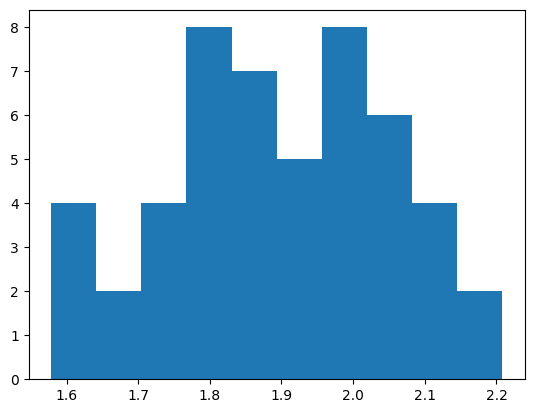

In [4]:
import matplotlib.pyplot as plt

# you can search for results of specific simulations as such
# DataSet[sample size].sel(var_param=<>, estimates=<>)
sigma_ms = DataSets[1000].sel(var_param = 2, estimates = "sigma_m")

# Here we plot the estimates of sigma_m when the theoretical value is 2 and the sample size is 1000
plt.hist(sigma_ms)
plt.show()

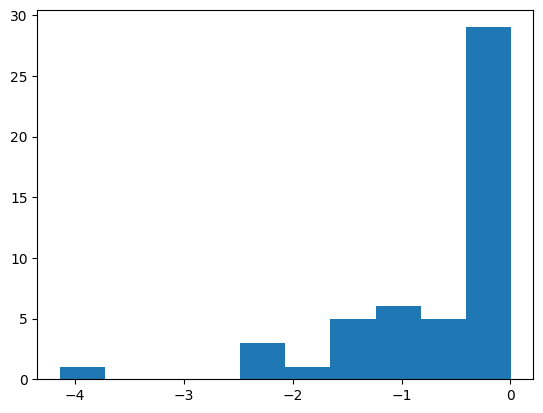

In [5]:
# Here we plot the lrt when the theoreticla value of sigma_m is 0, and the sample size is 1000
lrt = DataSets[1000].sel(var_param = 0, estimates = "lrt")

plt.hist(lrt)
plt.show()

